In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import os
import sys

import fitsio
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.table import Table
import healpy as hp
from healpy.newvisufunc import projview
import pymaster as nmt

#sys.path.insert(0, '/home/aew492/lss-dipoles')
#sys.path.insert(0, '/home/investigator/code/lss-dipoles')
sys.path.insert(0, '..')
import tools
from qso_sample import QSOSample
import dipole
import ellisbaldwin
import multipoles
from jackknife import get_longitude_subsamples_from_hpmap, compute_jackknife_uncertainty, covar_jackknife

In [4]:
import matplotlib
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['legend.fontsize'] = 16

matplotlib.rc('text', usetex=True)

In [5]:
basedir = '../../quasar_data_abby/catalogs'

In [6]:
color_quaia = 'mediumvioletred'
color_catwise = 'teal'
lw = 2
lw_grid = 0.5

### functions

In [7]:
def C_1(dipole_amplitude):  # from the new Abghari et al. (including Douglas Scott), eq. 3.3
    # return dipole_amplitude**2 / 3
    return 4 * np.pi / 9 * dipole_amplitude**2

def D(C_1):
    return np.sqrt(C_1) * 9 / (4 * np.pi)

In [8]:
# define function for jackknife: output needs to be just the Cells, to compute the uncertainty
def Cells_for_jk(overdensity_map, Wmask, max_ell, selfunc=None):
    ells, Cells = multipoles.compute_Cells_in_overdensity_map(overdensity_map, Wmask, max_ell, selfunc=selfunc)
    return Cells

### load samples and construct overdensity maps

In [9]:
# some key variables !!

# ABBY
#catdir = '/scratch/aew492/quasars/catalogs'
#selfuncdir_quaia = os.path.join(catdir, 'quaia/selfuncs')
#selfuncdir_catwise = os.path.join(catdir, 'catwise_agns/selfuncs')

# KSF
catdir =  '../../quasar_data_abby/catalogs'
selfuncdir_quaia = '../../gaia-quasars-lss/data/maps/'
selfuncdir_catwise = '../../gaia-quasars-lss/data/maps/'

mask_fn = os.path.join(catdir, 'masks/mask_master_hpx_r1.0.fits')
Wmask = 0.1  # fiducial regularization
max_ell = 8  # max ell to fit

#### CatWISE

In [10]:
# instantiate dipole object:
d = QSOSample(initial_catfn=os.path.join(catdir, 'catwise_agns/catwise_agns_master.fits'),
              mask_fn=mask_fn,
              mag='W1', maglim=16.4,
              basedir=basedir,
              blim=30)
d.cut_galactic_plane()  # cuts all sources with |b|<blim from the working source table

# get the expected dipole amplitude (before we make the magnitude cut at maglim, so we can compute the number-count slope)
expected_dipamp_catwise = ellisbaldwin.compute_expected_dipole_wise(d.table, maglimit=d.maglim,
                                                            min_w1=16., max_w1=16.5)  # reasonable min and max around the magnitude limit
d.cut_mag()  # now we cut all sources fainter than the input magnitude limit

loading initial catalog, ../../quasar_data_abby/catalogs/catwise_agns/catwise_agns_master.fits
8532854 sources in initial catalog.
cut |b| <= 30 -> 4479160 sources left.
computing expected dipole from Ellis-Baldwin:
	number-count slope x = 1.748
	effective alpha = 1.270
	expected dipole amplitude = 0.0074
cut W1 > 16.4 -> 1400045 sources left.


In [11]:
# at the healpix level:

# load selection function
# selfunc_catwise = d.get_selfunc(os.path.join(catdir, 'catwise_agns/selfuncs',
#                                             f'selection_function_NSIDE{d.NSIDE}_catwise_pluszodis.fits'))
selfunc_catwise = d.get_selfunc(os.path.join(selfuncdir_catwise,
                                            f'selection_function_NSIDE{d.NSIDE}_catwise_pluszodis.fits'))

# construct overdensity map with no selection function
overdensity_map_catwise = d.construct_overdensity_map(selfunc=None)

# and with the selection function
overdensity_map_sf_catwise = d.construct_overdensity_map(selfunc=selfunc_catwise)

constructing overdensity map
selection function not provided; assuming completeness = 1 in every pixel
defining healpix mask...
	masked pixels |b|<30deg, from mask_fn, and where completeness < 0.5
constructing overdensity map


In [12]:
# for CatWISE, we also want to correct for a density trend in ecliptic latitude, to match Secrest:
# get the ecliptic latitudes of each healpixel
lon, lat = hp.pix2ang(d.NSIDE, np.arange(hp.nside2npix(d.NSIDE)), lonlat=True)
elat = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').geocentrictrueecliptic.lat

# construct the masked datamap
masked_datamap = d.construct_masked_datamap(selfunc=None, return_map=True)

# fit a line: density vs elat
idx = ~np.isnan(elat) & ~np.isnan(masked_datamap)
p = np.polyfit(np.abs(elat)[idx], masked_datamap[idx], deg=1)
# correct the densities and fit to the corrected densities
map_elatcorr = masked_datamap - np.polyval(p, np.abs(elat.value)) + p[1]
p_corr = np.polyfit(np.abs(elat)[idx], map_elatcorr[idx], deg=1) # in case we want to check the corrected trend
# then the overdensity map is
overdensity_map_elat_catwise = map_elatcorr / np.nanmean(map_elatcorr) - 1

selection function not provided; assuming completeness = 1 in every pixel


#### Quaia

In [15]:
# instantiate dipole object:
d = QSOSample(initial_catfn=os.path.join(catdir, 'quaia/quaia_G20.5.fits'),
              mask_fn=mask_fn,
              mag='g', maglim=20.,
              blim=30)
d.cut_galactic_plane()  # cuts all sources with |b|<blim from the working source table

# get the expected dipole amplitude (before we make the magnitude cut at maglim, so we can compute the number-count slope)
expected_dipamp_quaia = ellisbaldwin.compute_expected_dipole_gaia(d.table, maglimit=d.maglim,
                                                            min_g=19.5, max_g=20.5)  # reasonable min and max around the magnitude limit
d.cut_mag()  # now we cut all sources fainter than the input magnitude limit

loading initial catalog, ../../quasar_data_abby/catalogs/quaia/quaia_G20.5.fits
1295502 sources in initial catalog.
cut |b| <= 30 -> 917566 sources left.
computing expected dipole from Ellis-Baldwin:
	number-count slope x = 1.309
	effective alpha = 0.713
	expected dipole amplitude = 0.0052
cut G > 20.0 -> 530364 sources left.


In [16]:

# at the healpix level:

# load selection function
selfunc_quaia_blim15 = d.get_selfunc(os.path.join(selfuncdir_quaia,
                                            f'selection_function_NSIDE{d.NSIDE}_G{d.maglim}_blim15.fits')) # note the blim15 !
# overdensity map, corrected by selection function
overdensity_map_sf_quaia_blim15 = d.construct_overdensity_map(selfunc=selfunc_quaia_blim15)

constructing overdensity map
defining healpix mask...
	masked pixels |b|<30deg, from mask_fn, and where completeness < 0.5


In [17]:
# at the healpix level:

# load selection function
selfunc_quaia_full = d.get_selfunc(os.path.join(selfuncdir_quaia,
                                            f'selection_function_NSIDE{d.NSIDE}_G{d.maglim}.fits'))
# overdensity map, corrected by selection function
overdensity_map_sf_quaia_full = d.construct_overdensity_map(selfunc=selfunc_quaia_full)

constructing overdensity map


In [18]:
# at the healpix level:

# load selection function
selfunc_quaia_fullzodis = d.get_selfunc(os.path.join(selfuncdir_quaia,
                                            f'selection_function_NSIDE{d.NSIDE}_G{d.maglim}_pluszodis.fits'))
# overdensity map, corrected by selection function
overdensity_map_sf_quaia_fullzodis = d.construct_overdensity_map(selfunc=selfunc_quaia_fullzodis)

constructing overdensity map


In [19]:
# CHOOSE FIDUCIAL QUAIA SELFUNC
selfunc_quaia = selfunc_quaia_full
overdensity_map_sf_quaia = overdensity_map_sf_quaia_full

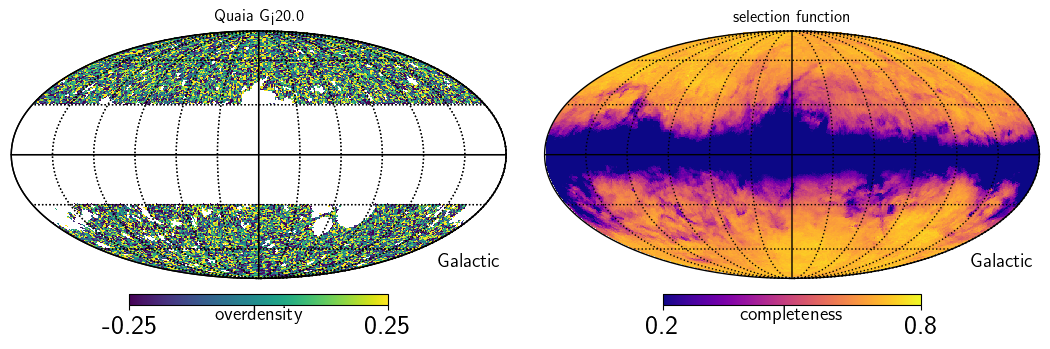

In [62]:
# plot
fig = plt.figure(figsize=(16,3))
hp.mollview(overdensity_map_sf_quaia, coord=['C','G'], min=-0.25, max=0.25, badcolor='w', fig=fig, sub=(1,3,1),
            unit='overdensity', title=f'Quaia G<{d.maglim}')
hp.graticule()
hp.mollview(selfunc_quaia, coord=['C','G'], min=0.2, max=0.8, badcolor='w', fig=fig, sub=(1,3,2), cmap='plasma',
            unit='completeness', title=f'selection function')
hp.graticule()

# C_ells direct

In [119]:
# Quaia
ells, Cells_quaia = multipoles.compute_Cells_in_overdensity_map(overdensity_map_sf_quaia,
                                                          Wmask=Wmask, max_ell=max_ell, selfunc=selfunc_quaia)

In [121]:
save_dir = '../../quasar_data_abby/jackknife'
Cells_quaia_std = np.load(os.path.join(save_dir, f'jk_Cells_std_quaia_sfcorr_ellmax{max_ell}.npy'),
                            allow_pickle=True).item()['Cells_std']

In [120]:
noise_dir = '../../quasar_data_abby/noise_Cells'
res_quaia = np.load(f'{noise_dir}/quaia/noise_Cells_fullsky_ellmax1_100trials.npy', allow_pickle=True).item()
noise_quaia_Cell = res_quaia['Cells_fullsky'][0]

In [122]:
expected_C1_quaia = C_1(expected_dipamp_quaia)

# NaMaster

In [57]:
np.min(selfunc_quaia)

0.0

26989


In [68]:
map_quaia = overdensity_map_sf_quaia.copy()
map_quaia[np.isnan(map_quaia)] = 0

In [69]:
print(np.sum(np.isnan(overdensity_map_sf_quaia)))
print(np.sum(np.isnan(map_quaia)))

26989
0


In [70]:
f_quaia = nmt.NmtField(selfunc_quaia, [map_quaia], n_iter=0)

In [71]:
print(f_quaia.get_maps(), f_quaia.get_maps().shape)
print(np.sum(np.isnan(f_quaia.get_maps()[0])))

[[0. 0. 0. ... 0. 0. 0.]] (1, 49152)
0


In [109]:
# Bins
#b = nmt.NmtBin(d.NSIDE, nlb=30)
l_max = 8
ells = np.arange(1, l_max+1)
bpws = np.arange(len(ells))
weights = np.ones(len(ells))/len(ells)
b = nmt.NmtBin(d.NSIDE, ells=ells, bpws=bpws, weights=weights)
#b = nmt.NmtBin(d.NSIDE, nlb=1, lmax=3)

leff = b.get_effective_ells()
print(leff)

[1. 2. 3. 4. 5. 6. 7. 8.]


In [153]:
cat = Table.read(d.initial_catfn)
ipix = hp.ang2pix(d.NSIDE, cat['ra'], cat['dec'], lonlat=True)

# alonso masked also selfunc<0.5
mask = selfunc_quaia
mask_b = selfunc_quaia > 0
maskflag = mask_b[ipix]
c = cat[maskflag]
ipix = ipix[maskflag]

# Calculate overdensity field
nmap = np.bincount(ipix, minlength=npix)
nmean = np.sum(nmap*mask_b)/np.sum(mask*mask_b)
delta = np.zeros(npix)
delta[mask_b] = nmap[mask_b]/(nmean*mask[mask_b])-1

# Calculate coupled noise power spectrum

nmean_srad = nmean * npix / (4*np.pi)
nl_coupled = np.mean(mask) / nmean_srad * np.ones((1, 3*d.NSIDE))
print(nmean, npix, nmean_srad)
print(nl_coupled.shape, nl_coupled[0,:5])

57.12829815120372 49152 223451.16158832618
(1, 192) [2.06365448e-06 2.06365448e-06 2.06365448e-06 2.06365448e-06
 2.06365448e-06]


In [142]:
# Calculator
def get_cl(f1, f2, pnl=None):
    pcl = nmt.compute_coupled_cell(f1, f2)
    w = nmt.NmtWorkspace()
    w.compute_coupling_matrix(f1, f2, b)
    cl = w.decouple_cell(pcl)
    if pnl is not None:
        nl = w.decouple_cell(pnl)
        cl -= nl
    else:
        nl = np.zeros_like(cl)
    wins = w.get_bandpower_windows()
    return cl, nl, w, wins.squeeze()

In [155]:
cl, nl, w, Bbl = get_cl(f_quaia, f_quaia, pnl=nl_coupled)
#cl, nl, w, Bbl = get_cl(f_quaia, f_quaia, pnl=None)
print(cl)

[[9.66143593e-05 2.88339643e-05 3.05251340e-06 8.08471711e-06
  2.62281525e-05 2.37934756e-05 1.36506033e-05 7.84876328e-06]]


In [157]:
cl_full = nmt.compute_full_master(f_quaia, f_quaia, b)
print(cl_full)

[[1.04213994e-04 3.66794351e-05 1.06840466e-05 1.57441328e-05
  3.39960224e-05 3.15634664e-05 2.21314219e-05 1.63288941e-05]]


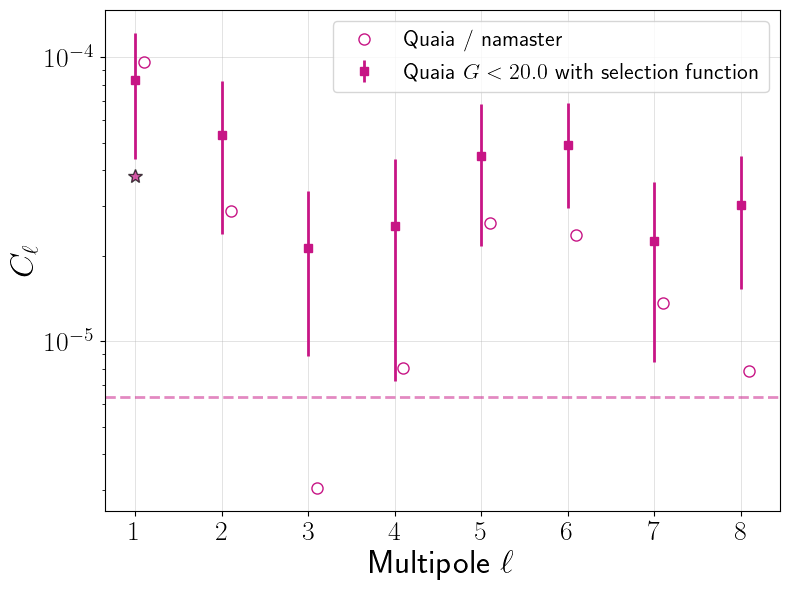

In [159]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
#kwargs = dict(ls='None', ms=6, alpha=0.6, capsize=2, lw=lw)
kwargs = dict(ls='None', ms=6, alpha=1, lw=lw)

ax.plot(leff+0.1, cl[0], color=color_quaia, marker='o', markersize=8, markerfacecolor='None',
        ls='None', label='Quaia / namaster')
# ax.plot(leff+0.1, cl_full[0], color=color_quaia, marker='o', markersize=8, markerfacecolor='None',
#         ls='None', label='Quaia / namaster')

ax.errorbar(ells[1:], Cells_quaia[1:], yerr=Cells_quaia_std[1:],
            c=color_quaia, label=r'Quaia $G<20.0$ with selection function', marker='s', **kwargs)

# expected dipole amplitude
kwargs = dict(marker='*', ms=10, mec='k', alpha=0.7)
ax.plot(1, expected_C1_quaia, c=color_quaia, **kwargs, lw=lw)
# manual label
marker = mpl.lines.Line2D([0],[0], c='None', label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5, lw=lw)
ax.axhline(noise_quaia_Cell, c=color_quaia, **kwargs)
#ax.axhline(noise_quaia_cross, c=color_quaia, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], label='Shot noise', c='k', **kwargs)

# model + shot noise
#ax.plot(ells_mod, Cells_mod + noise_quaia_Cell, c=color_quaia, label='Model + shot noise', alpha=0.5)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)
#ax.set_xlim(ells[1:][0] - 0.5, ells[1:][-1] + 0.5)
#ax.set_ylim(2e-6, 3e-4)
ax.set_xlabel(r'Multipole $\ell$')
#ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
# ax.set_title(r'Angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
#ax.legend(loc=1, handles=handles)
ax.legend(loc=1)